In [54]:
import numpy as np
import tensorflow as tf

from keras.applications import ResNet50
from keras.layers import Dense, Flatten, Input
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight


In [2]:
print(
"TensorFlow version:", tf.__version__)
print("Num GPUs Available", len(tf.config.list_physical_devices('GPU')))

TensorFlow version: 2.9.3
Num GPUs Available 1


In [41]:
seed_value = 322

datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    validation_split=0.2,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = datagen.flow_from_directory(
    'PetImages',
    target_size=(224, 224),
    color_mode='grayscale',
    batch_size=32,
    class_mode='binary',
    subset='training'
    )

validation_generator = datagen.flow_from_directory(
    'PetImages',
    target_size=(224, 224),
    color_mode='grayscale',
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

test_datagen = ImageDataGenerator(rescale=1.0/255.0)

test_generator = datagen.flow_from_directory(
    'PetImages_test',
    target_size=(224, 224),
    color_mode='grayscale',
    batch_size=32,
    class_mode='binary'
)

Found 18390 images belonging to 2 classes.
Found 4596 images belonging to 2 classes.
Found 2008 images belonging to 2 classes.


In [30]:
def convert_grayscale_to_rgb(batch):
    tensor_batch = tf.convert_to_tensor(batch)
    
    rgb_batch = tf.image.grayscale_to_rgb(tensor_batch)
    return rgb_batch

def rgb_wrapper(generator):
    for batch, labels in generator:
        rgb_batch = convert_grayscale_to_rgb(batch)
        yield rgb_batch, labels


train_generator_rgb = rgb_wrapper(train_generator)
validation_generator_rgb = rgb_wrapper(validation_generator)
test_generator_rgb = rgb_wrapper(test_generator)


# 1:a modellen

In [5]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=x)

model.compile(optimizer=Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=['accuracy'])

In [6]:
history = model.fit(
    train_generator_rgb,
    validation_data=validation_generator_rgb,
    epochs=10,
    steps_per_epoch=train_generator.samples // 32,
    validation_steps=validation_generator.samples // 32
)

Epoch 1/10
 11/574 [..............................] - ETA: 32s - loss: 1.1944 - accuracy: 0.5057

c:\Users\TheIm\Documents\vscode files\transferlearning\.venv\lib\site-packages\PIL\TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))


574/574 [==============================] - 48s 74ms/step - loss: 0.6482 - accuracy: 0.6402 - val_loss: 0.5923 - val_accuracy: 0.6761
Epoch 2/10
574/574 [==============================] - 42s 72ms/step - loss: 0.5980 - accuracy: 0.6802 - val_loss: 0.5918 - val_accuracy: 0.6713
Epoch 3/10
574/574 [==============================] - 43s 74ms/step - loss: 0.5836 - accuracy: 0.6862 - val_loss: 0.5562 - val_accuracy: 0.7216
Epoch 4/10
574/574 [==============================] - 42s 74ms/step - loss: 0.5617 - accuracy: 0.7092 - val_loss: 0.5650 - val_accuracy: 0.7074
Epoch 5/10
574/574 [==============================] - 43s 75ms/step - loss: 0.5472 - accuracy: 0.7219 - val_loss: 0.5381 - val_accuracy: 0.7347
Epoch 6/10
574/574 [==============================] - 41s 71ms/step - loss: 0.5336 - accuracy: 0.7315 - val_loss: 0.5244 - val_accuracy: 0.7404
Epoch 7/10
574/574 [==============================] - 41s 72ms/step - loss: 0.5310 - accuracy: 0.7388 - val_loss: 0.5439 - val_accuracy: 0.7181
Epo

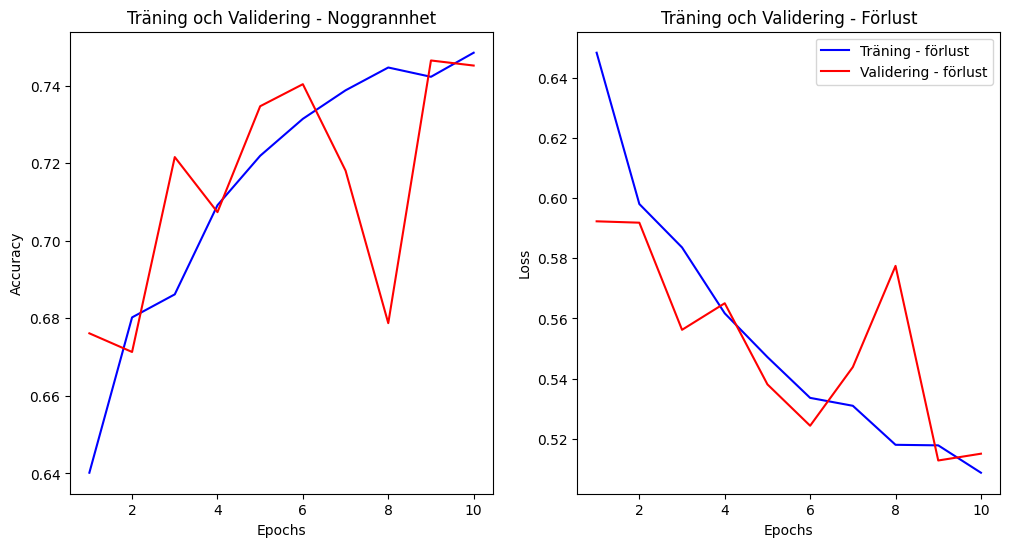

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc) + 1)

plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Träning - noggranhet')
plt.plot(epochs, val_acc, 'r', label='Validering - noggrannhet')
plt.title('Träning och Validering - Noggrannhet')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Träning - förlust')
plt.plot(epochs, val_loss, 'r', label='Validering - förlust')
plt.title('Träning och Validering - Förlust')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()
plt.show()

In [48]:
# Make sure you create a new instance of the test generator if needed
test_generator_rgb = rgb_wrapper(test_generator)  # Ensure you're using the RGB wrapper

steps_per_epoch = test_generator.samples // test_generator.batch_size
# Make predictions with the test generator
predictions = model.predict(test_generator_rgb, steps=steps_per_epoch, verbose=1)

# Convert predictions to class labels (use np.round for binary classification)
predicted_classes = np.round(predictions).astype(int)

# Get true classes from the test generator
true_classes = test_generator.classes[:len(predicted_classes)]  # Ensure the lengths match

# Retrieve class labels (the actual names of the classes from test_generator)
class_labels = list(test_generator.class_indices.keys())

# Generate the classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)

# Print the report
print(report)


62/62 [==============================] - 8s 132ms/step
              precision    recall  f1-score   support

         Cat       0.49      0.21      0.29      1004
         Dog       0.49      0.78      0.60       972

    accuracy                           0.49      1976
   macro avg       0.49      0.49      0.45      1976
weighted avg       0.49      0.49      0.44      1976



# 2:a modellen

In [55]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers[:100]:
    layer.trainable = False
for layer in base_model.layers[100:]:
    layer.trainable = True

x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
callbacks = [early_stopping, model_checkpoint]

class_weights = compute_class_weight('balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)
class_weights_dict = dict(enumerate(class_weights))
print("Class weights: ", class_weights_dict)


model = Model(inputs=base_model.input, outputs=x)

model.compile(optimizer=Adam(learning_rate=0.00001), loss="binary_crossentropy", metrics=['accuracy'])

Class weights:  {0: 1.0, 1: 1.0}


In [57]:
history1 = model.fit(
    train_generator_rgb,
    validation_data=validation_generator_rgb,
    epochs=25,
    steps_per_epoch=train_generator.samples // 32,
    validation_steps=validation_generator.samples // 32,
    callbacks=callbacks,
    class_weight=class_weights_dict
)

Epoch 1/25
324/574 [===============>..............] - ETA: 44s - loss: 0.6358 - accuracy: 0.6489

c:\Users\TheIm\Documents\vscode files\transferlearning\.venv\lib\site-packages\PIL\TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))


574/574 [==============================] - 135s 223ms/step - loss: 0.6080 - accuracy: 0.6704 - val_loss: 0.5433 - val_accuracy: 0.7262
Epoch 2/25
574/574 [==============================] - 115s 200ms/step - loss: 0.5347 - accuracy: 0.7304 - val_loss: 0.5842 - val_accuracy: 0.7039
Epoch 3/25
574/574 [==============================] - 106s 184ms/step - loss: 0.4977 - accuracy: 0.7567 - val_loss: 0.4771 - val_accuracy: 0.7703
Epoch 4/25
574/574 [==============================] - 120s 209ms/step - loss: 0.4777 - accuracy: 0.7692 - val_loss: 0.4654 - val_accuracy: 0.7714
Epoch 5/25
574/574 [==============================] - 118s 205ms/step - loss: 0.4577 - accuracy: 0.7824 - val_loss: 0.4560 - val_accuracy: 0.7900
Epoch 6/25
574/574 [==============================] - 132s 230ms/step - loss: 0.4386 - accuracy: 0.7941 - val_loss: 0.4527 - val_accuracy: 0.7753
Epoch 7/25
574/574 [==============================] - 112s 196ms/step - loss: 0.4274 - accuracy: 0.7985 - val_loss: 0.4956 - val_accura

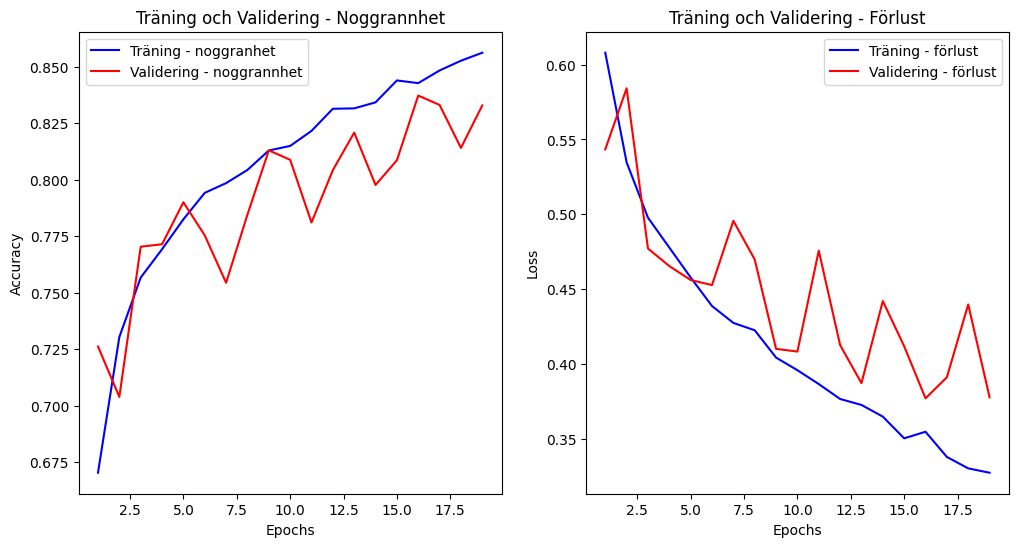

In [61]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs = range(1,len(acc) + 1)

plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Träning - noggranhet')
plt.plot(epochs, val_acc, 'r', label='Validering - noggrannhet')
plt.title('Träning och Validering - Noggrannhet')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Träning - förlust')
plt.plot(epochs, val_loss, 'r', label='Validering - förlust')
plt.title('Träning och Validering - Förlust')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [62]:
# Make sure you create a new instance of the test generator if needed
test_generator_rgb = rgb_wrapper(test_generator)  # Ensure you're using the RGB wrapper

steps_per_epoch = test_generator.samples // test_generator.batch_size
# Make predictions with the test generator
predictions = model.predict(test_generator_rgb, steps=steps_per_epoch, verbose=1)

# Convert predictions to class labels (use np.round for binary classification)
predicted_classes = np.round(predictions).astype(int)

# Get true classes from the test generator
true_classes = test_generator.classes[:len(predicted_classes)]  # Ensure the lengths match

# Retrieve class labels (the actual names of the classes from test_generator)
class_labels = list(test_generator.class_indices.keys())

# Generate the classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)

# Print the report
print(report)


62/62 [==============================] - 13s 218ms/step
              precision    recall  f1-score   support

         Cat       0.50      0.45      0.48      1004
         Dog       0.49      0.53      0.51       972

    accuracy                           0.49      1976
   macro avg       0.49      0.49      0.49      1976
weighted avg       0.49      0.49      0.49      1976

